In [24]:
import multiprocessing

import pandas as pd
from kaggle.competitions import twosigmanews

from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt

In [44]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [ ]:
env = twosigmanews.make_env()
print('Done!')

In [ ]:
(market_train_df, news_train_df) = env.get_training_data()

In [ ]:
market_train_df.head()

In [ ]:
market_train_df.info()

In [32]:
market_train_df['dayofweek'] = market_train_df.time.dt.dayofweek
market_train_df['month']  = market_train_df.time.dt.month
market_train_df['year']  = market_train_df.time.dt.year

cols = ['time', 'assetCode', 'assetName', 'universe', 'returnsOpenNextMktres10']
col = [c for c in market_train_df.columns if c not in cols]

X = market_train_df[col]
y = market_train_df['returnsOpenNextMktres10']

In [33]:
X.head()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,dayofweek,month,year
0,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,3,2,2007
1,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,3,2,2007
2,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,3,2,2007
3,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,3,2,2007
4,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,3,2,2007


In [35]:
X, X_Val, y, y_Val = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [36]:
lgb_model = lgb.LGBMRegressor(objective='regression',
                        max_bin=10,
                        learning_rate=0.01,
                        num_leaves = 80,
                        n_estimators = 30
                       )

In [37]:
# Fit the best algorithm to the data. 
lgb_model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.01, max_bin=10, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=30,
       n_jobs=-1, num_leaves=80, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [41]:
# prediction
lgb_predictions = lgb_model.predict(X_Val)

In [ ]:
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5]
        }

# Initialize XGB and GridSearch
xgb_model = xgb.XGBRegressor(n_jobs=cpu_count)

grid = GridSearchCV(xgb_model, params)
grid.fit(X, y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
# Set the clf to the best combination of parameters
xgb_model = grid.best_estimator_
print(xgb_model)

In [ ]:
xgb.plot_importance(model)

In [ ]:
# Fit the best algorithm to the data. 
xgb_model.fit(X, y)

In [ ]:
# prediction
predictions = xgb_model.predict(X_val)

Text(0.5,1,'Prediction using xgboost')

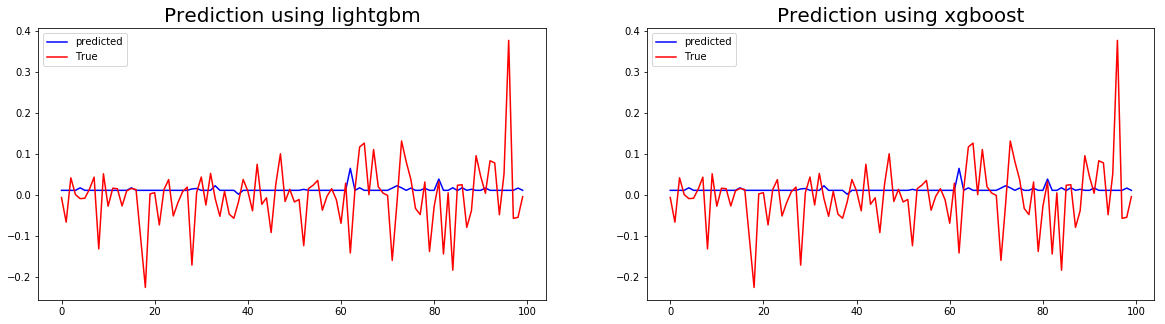

In [47]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(lgb_predictions[:100], 'b', label='predicted')
plt.plot(y_Val[:100], 'r', label='True')
plt.legend()
plt.title('Prediction using lightgbm', fontsize=20)

plt.subplot(1,2,2)
plt.plot(lgb_predictions[:100], 'b', label='predicted')
plt.plot(y_Val[:100], 'r', label='True')
plt.legend()
plt.title('Prediction using xgboost', fontsize=20)